In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cvxpy as cp
from datetime import datetime
pd.set_option("display.max_columns", None)

In [22]:
close_prices = pd.read_csv('sp100_daily_value.csv', index_col=0, parse_dates=True)
daily_returns = pd.read_csv('sp100_daily_change.csv', index_col=0, parse_dates=True)

In [23]:
daily_returns.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02 00:00:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-01-03 00:00:00-05:00,-0.007488,0.004005,-0.003004,-0.025942,-0.014274,-0.003341,-0.023524,0.011096,-0.018829,-0.009738,...,-0.014888,0.004988,-0.007107,-0.005052,-0.026418,-0.003438,0.007202,-0.013177,0.000063,0.008402
2024-01-04 00:00:00-05:00,-0.012700,0.006232,0.013331,-0.002456,-0.008290,0.000292,0.005099,0.008248,0.003587,-0.026268,...,-0.013614,0.006254,-0.002648,-0.003491,0.010760,0.006318,0.005363,0.012325,-0.009667,-0.008719
2024-01-05 00:00:00-05:00,-0.004013,0.004212,-0.001622,-0.001394,-0.004321,0.005537,0.018896,-0.000561,-0.005477,0.004634,...,0.003831,-0.014741,-0.004771,0.011020,0.013886,0.000308,0.021082,0.012987,-0.006656,0.003030
2024-01-08 00:00:00-05:00,0.024175,-0.004379,0.014440,0.011081,0.028250,-0.011448,0.054842,0.026007,0.008400,0.026577,...,0.020836,-0.001600,0.002959,0.007561,0.003424,0.010975,-0.002488,0.000000,0.009827,-0.016662


In [116]:
benchmark_weights = np.ones(len(daily_returns.columns)) / len(daily_returns.columns) #all stocks ave same weight
benchmark_returns = daily_returns.dot(benchmark_weights).values 

tickers = daily_returns.columns
n_stocks = len(tickers)
n_days = len(daily_returns)
q = 70  #Number of stocks to select

#Set Variables
weights = cp.Variable(n_stocks)
selected = cp.Variable(n_stocks, boolean=True)
portfolio_returns = daily_returns.values @ weights

#We waant to minimize tracking error variance
tracking_error = cp.sum_squares(portfolio_returns - benchmark_returns) / n_days

#Set OUr Constraints
constraints = [
    cp.sum(weights) == 1,
    weights >= 0.005 * selected,  #Min 0.5% if selected
    weights <= 0.2 * selected,   #Max 20% wieght if selected
    cp.sum(selected) == q, #Only q stock
]

#Solve
prob = cp.Problem(cp.Minimize(tracking_error), constraints)
prob.solve(solver=cp.ECOS_BB, max_iters=1000, verbose=True)

#Get + print Results
selected_stocks = tickers[selected.value > 0.5]
selected_weights = weights.value[selected.value > 0.5]

print(f"Selected {len(selected_stocks)} stocks:")
print(selected_stocks.tolist())
print("\nWeights:")
print({t: round(w, 4) for t, w in zip(selected_stocks, selected_weights)})
print(f"\nTracking Error Variance: {prob.value:.6f}")

                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 03 12:07:16 PM: Your problem has 200 variables, 202 constraints, and 0 parameters.
(CVXPY) Apr 03 12:07:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 03 12:07:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 03 12:07:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 03 12:07:16 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 03 12:07:16 PM: Compiling problem (target solver=ECOS_BB)

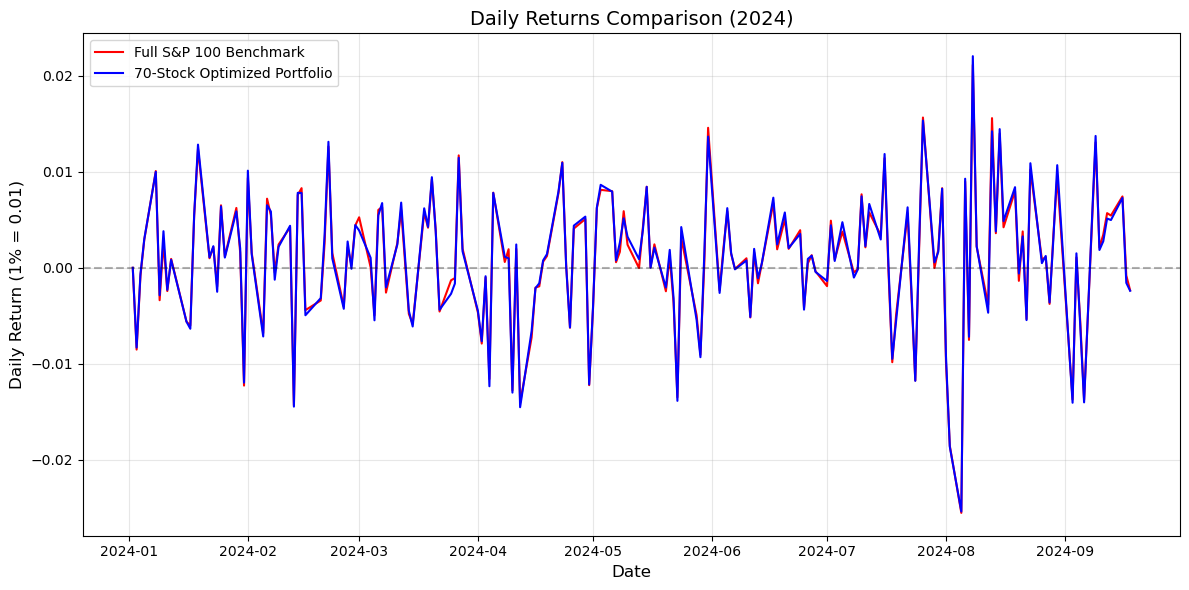

In [64]:
optimized_weights = pd.Series(weights.value, index=daily_returns.columns)
portfolio_returns = daily_returns @ optimized_weights

benchmark_weights = np.ones(len(daily_returns.columns)) / len(daily_returns.columns)
benchmark_returns = daily_returns @ benchmark_weights

#Performance df
performance = pd.DataFrame({
    'Benchmark': benchmark_returns,
    'Optimized_Portfolio': portfolio_returns
}, index=daily_returns.index)

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=performance, x=performance.index, y='Benchmark', color='red', label='Full S&P 100 Benchmark') #Actual SP100 red
sns.lineplot(data=performance, x=performance.index, y='Optimized_Portfolio',color='blue', label='70-Stock Optimized Portfolio') #Our version blue
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Daily Returns Comparison (2024)", fontsize=14)
plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

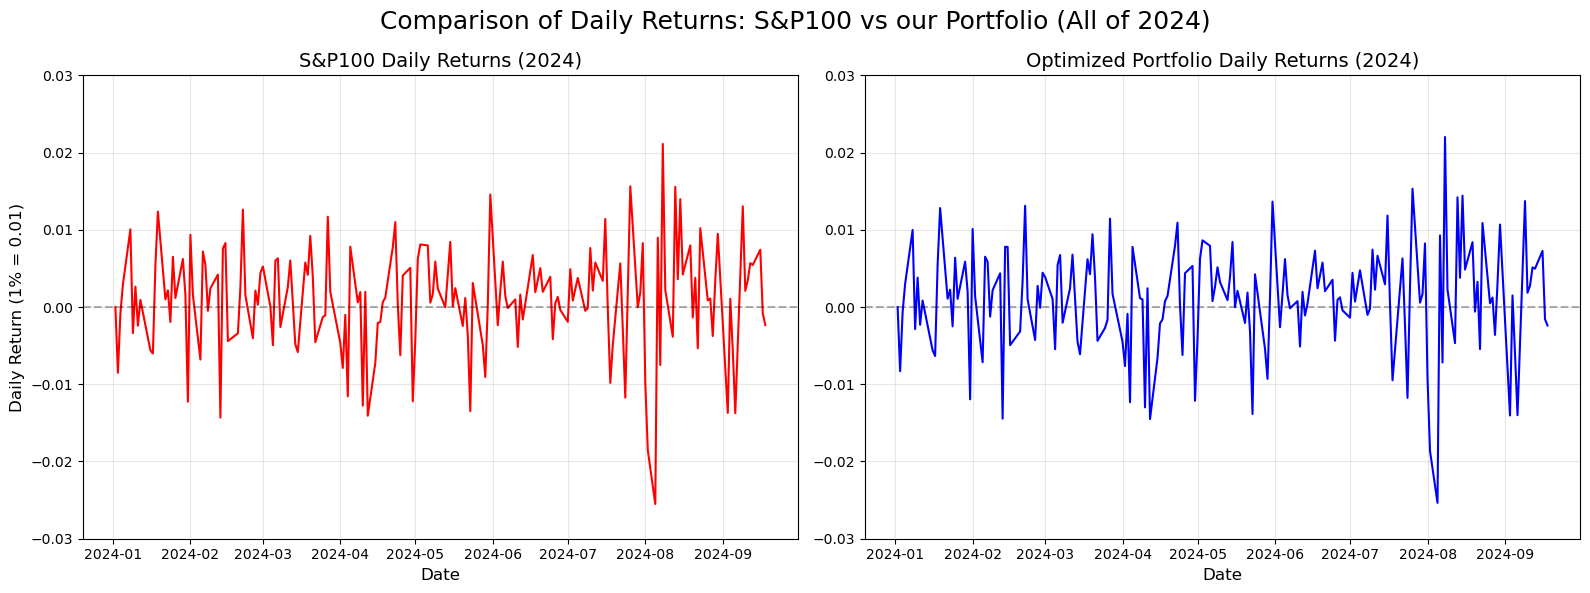

In [149]:
plt.figure(figsize=(16, 6))
plt.suptitle("Comparison of Daily Returns: S&P100 vs our Portfolio (All of 2024)",fontsize=18)

#SP100
plt.subplot(1, 2, 1)  #pos1
sns.lineplot(data=performance, x=performance.index, y='Benchmark', color='red')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("S&P100 Daily Returns (2024)", fontsize=14)
plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim(-0.03,0.03)
plt.grid(True, alpha=0.3)

#OUr stocks
plt.subplot(1, 2, 2) #pos2
sns.lineplot(data=performance, x=performance.index, y='Optimized_Portfolio', color='blue')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Optimized Portfolio Daily Returns (2024)", fontsize=14)
#plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.ylabel("")
plt.ylim(-0.03,0.03)
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Whats the difference?

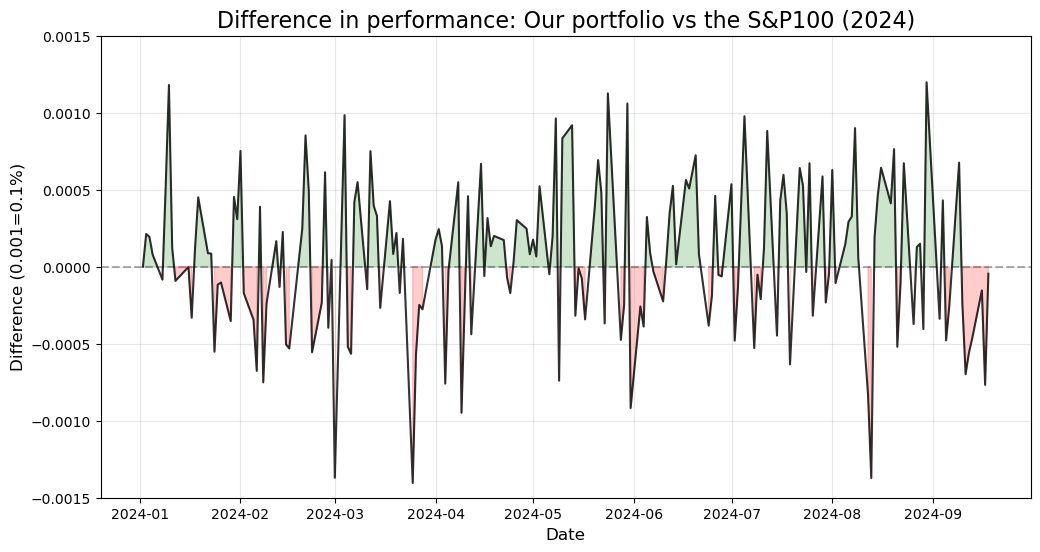

In [77]:
performance['Difference'] = performance['Optimized_Portfolio'] - performance['Benchmark']

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=performance, x=performance.index, y='Difference', 
             color='black', alpha=0.8)
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Difference in performance: Our portfolio vs the S&P100 (2024)", fontsize=16)
plt.ylabel("Difference (0.001=0.1%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim(-0.0015,0.0015)
plt.grid(True, alpha=0.3)

#fill positive and negatives
plt.fill_between(performance.index, performance['Difference'], 0, 
                 where=(performance['Difference'] > 0), 
                 color='green', alpha=0.2, interpolate=True)
plt.fill_between(performance.index, performance['Difference'], 0, 
                 where=(performance['Difference'] < 0), 
                 color='red', alpha=0.2)
plt.show()

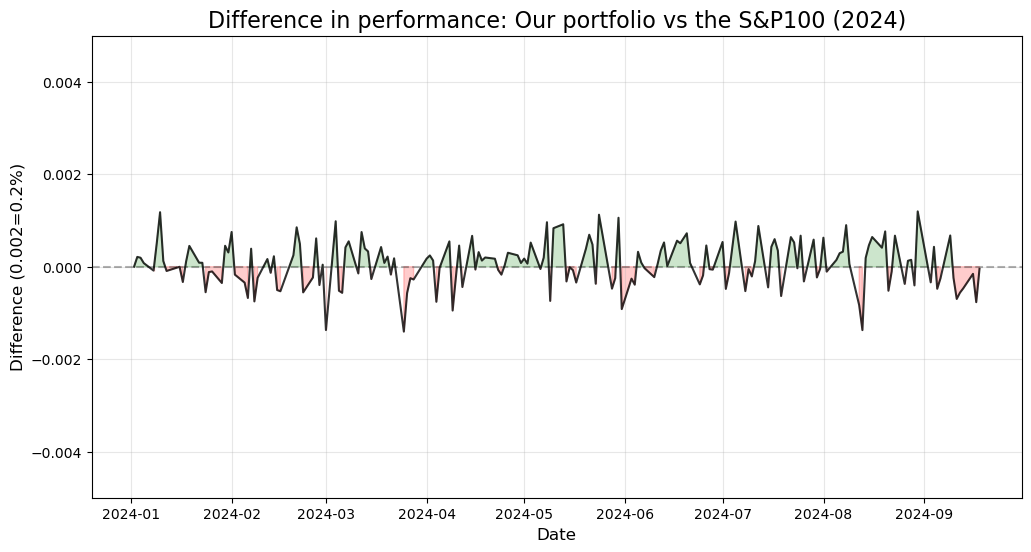

In [80]:
performance['Difference'] = performance['Optimized_Portfolio'] - performance['Benchmark']

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=performance, x=performance.index, y='Difference', 
             color='black', alpha=0.8)
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Difference in performance: Our portfolio vs the S&P100 (2024)", fontsize=16)
plt.ylabel("Difference (0.002=0.2%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim(-0.005,0.005)
plt.grid(True, alpha=0.3)

#fill positive and negatives
plt.fill_between(performance.index, performance['Difference'], 0, 
                 where=(performance['Difference'] > 0), 
                 color='green', alpha=0.2, interpolate=True)
plt.fill_between(performance.index, performance['Difference'], 0, 
                 where=(performance['Difference'] < 0), 
                 color='red', alpha=0.2)
plt.show()

## Over 1st quarter of 2024

In [126]:
DRQ1 = performance[0:61]#Q1

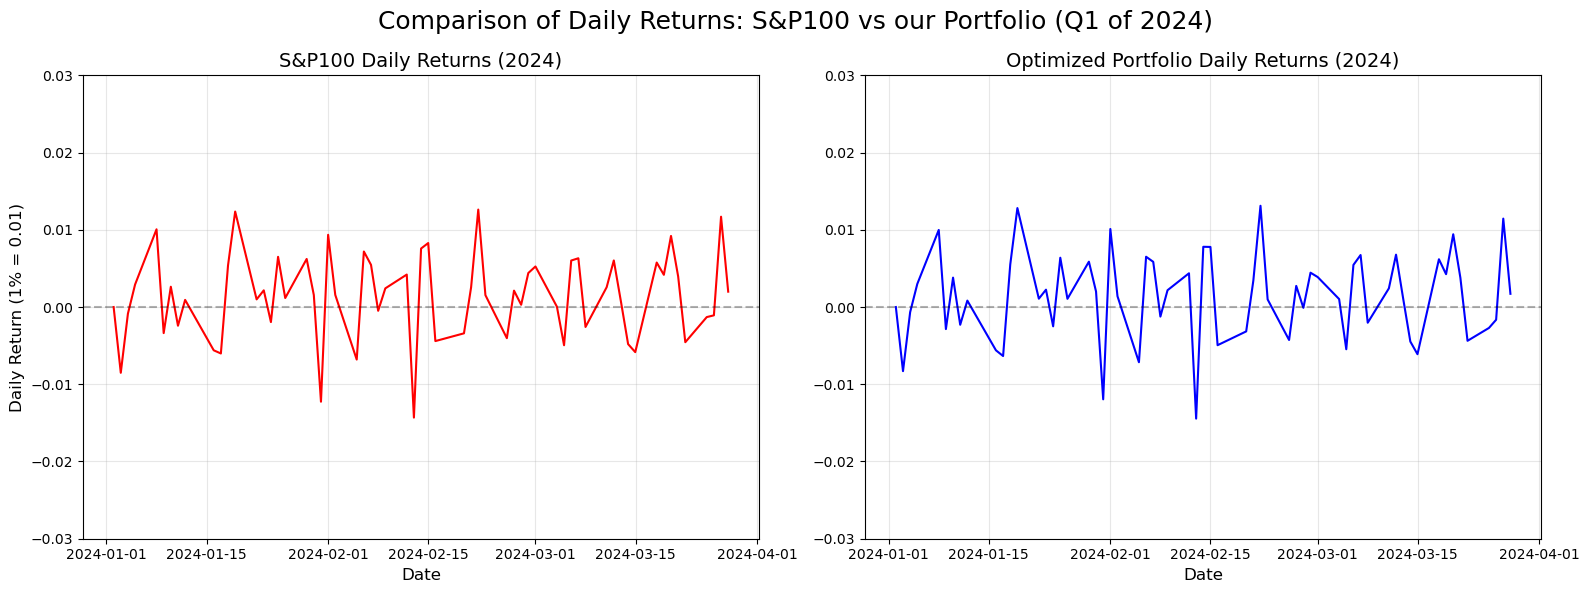

In [147]:
plt.figure(figsize=(16, 6))
plt.suptitle("Comparison of Daily Returns: S&P100 vs our Portfolio (Q1 of 2024)",fontsize=18)

#SP100
plt.subplot(1, 2, 1)  #pos1
sns.lineplot(data=DRQ1, x=DRQ1.index, y='Benchmark', color='red')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("S&P100 Daily Returns (2024)", fontsize=14)
plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim(-0.03,0.03)
plt.grid(True, alpha=0.3)

#OUr stocks
plt.subplot(1, 2, 2) #pos2
sns.lineplot(data=DRQ1, x=DRQ1.index, y='Optimized_Portfolio', color='blue')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Optimized Portfolio Daily Returns (2024)", fontsize=14)
#plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.ylabel("")
plt.ylim(-0.03,0.03)
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\hughp\AppData\Local\Temp\ipykernel_26216\267953482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DRQ1['Difference'] = DRQ1['Optimized_Portfolio'] - DRQ1['Benchmark']


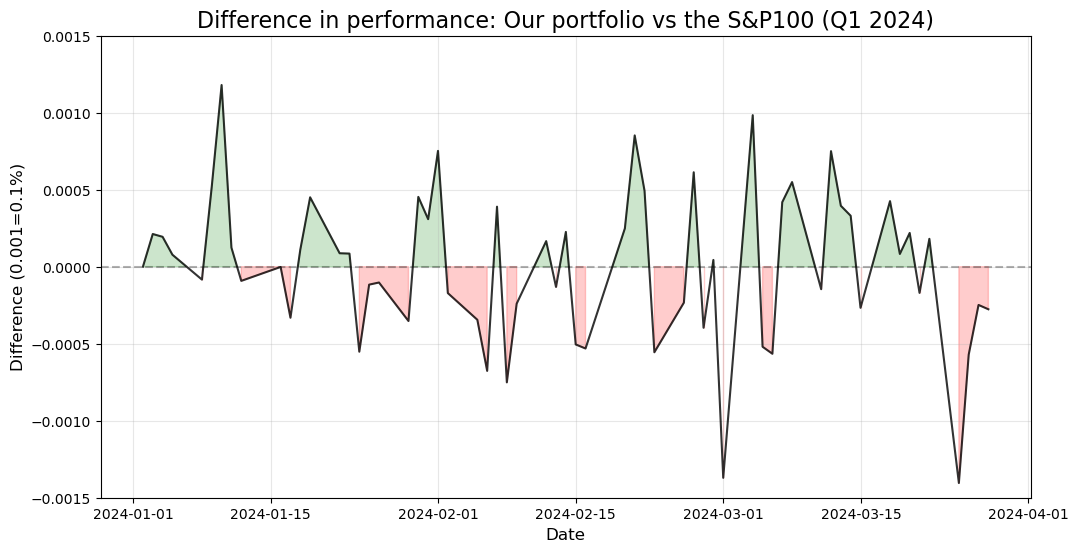

In [150]:
DRQ1['Difference'] = DRQ1['Optimized_Portfolio'] - DRQ1['Benchmark']

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=DRQ1, x=DRQ1.index, y='Difference', 
             color='black', alpha=0.8)
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Difference in performance: Our portfolio vs the S&P100 (Q1 2024)", fontsize=16)
plt.ylabel("Difference (0.001=0.1%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim(-0.0015,0.0015)
plt.grid(True, alpha=0.3)

#fill positive and negatives
plt.fill_between(DRQ1.index, DRQ1['Difference'], 0, 
                 where=(DRQ1['Difference'] > 0), 
                 color='green', alpha=0.2, interpolate=True)
plt.fill_between(DRQ1.index, DRQ1['Difference'], 0, 
                 where=(DRQ1['Difference'] < 0), 
                 color='red', alpha=0.2)
plt.show()

## Over first 2 quarters of 2024

In [125]:
DRQ2 = performance[0:124] #q2

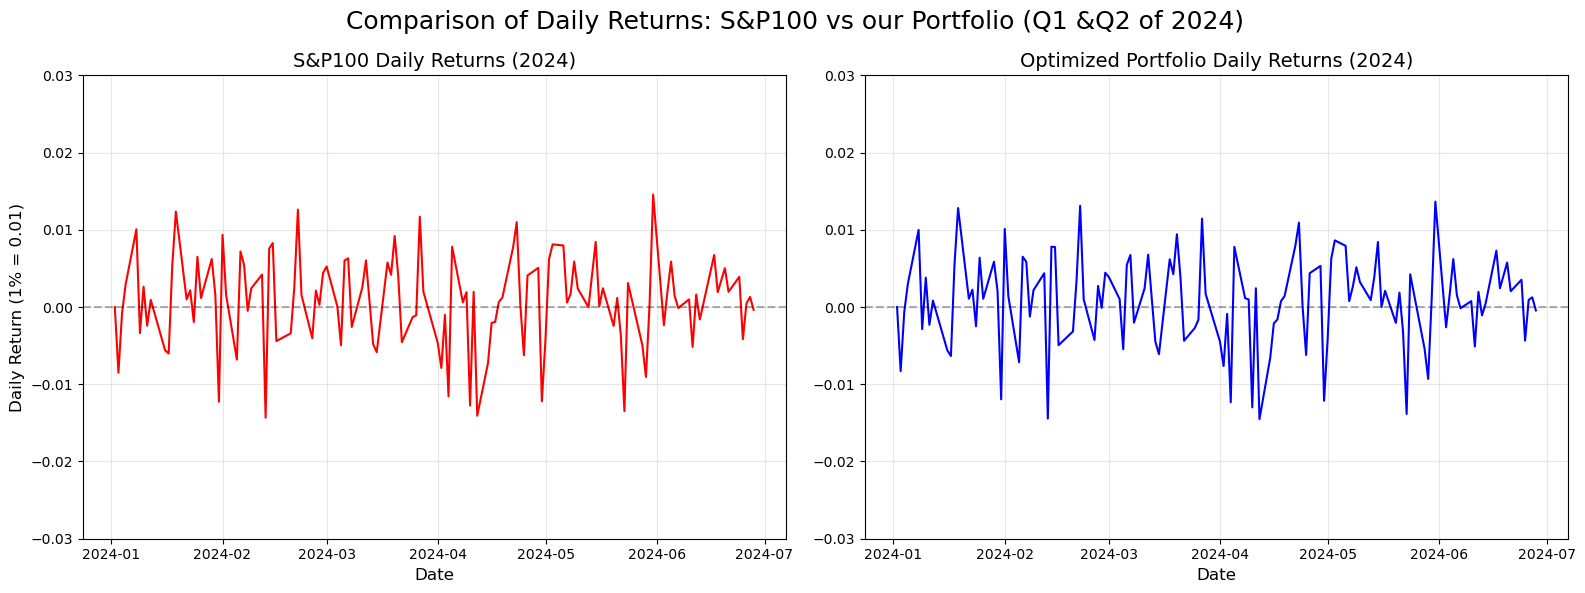

In [143]:
plt.figure(figsize=(16, 6))
plt.suptitle("Comparison of Daily Returns: S&P100 vs our Portfolio (Q1 &Q2 of 2024)",fontsize=18)
#SP100
plt.subplot(1, 2, 1)  #pos1
sns.lineplot(data=DRQ2, x=DRQ2.index, y='Benchmark', color='red')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("S&P100 Daily Returns (2024)", fontsize=14)
plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim(-0.03,0.03)
plt.grid(True, alpha=0.3)

#OUr stocks
plt.subplot(1, 2, 2) #pos2
sns.lineplot(data=DRQ2, x=DRQ2.index, y='Optimized_Portfolio', color='blue')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Optimized Portfolio Daily Returns (2024)", fontsize=14)
#plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.ylabel("")
plt.ylim(-0.03,0.03)
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\hughp\AppData\Local\Temp\ipykernel_26216\1250592838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DRQ2['Difference'] = DRQ2['Optimized_Portfolio'] - DRQ2['Benchmark']


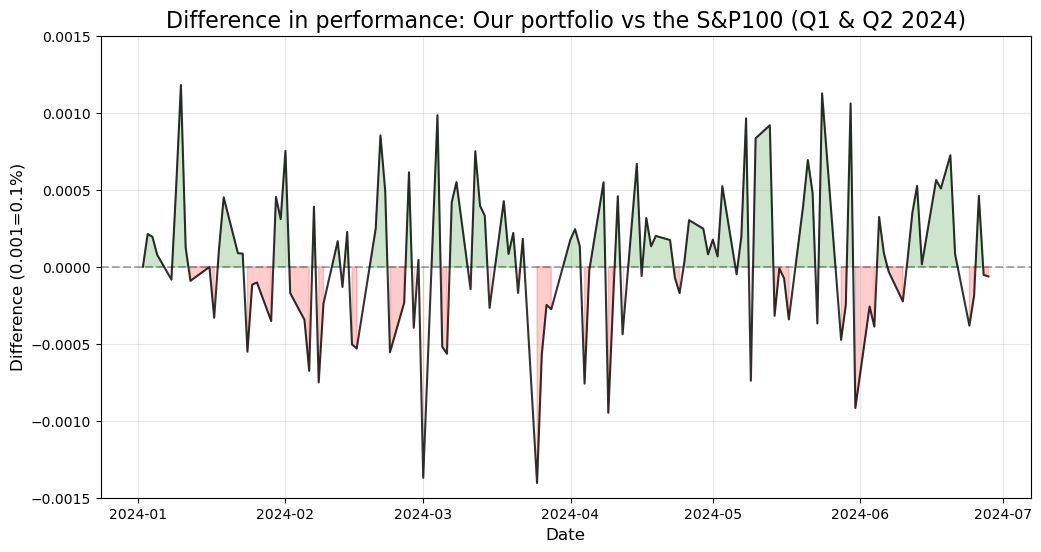

In [151]:
DRQ2['Difference'] = DRQ2['Optimized_Portfolio'] - DRQ2['Benchmark']

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=DRQ2, x=DRQ2.index, y='Difference', 
             color='black', alpha=0.8)
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Difference in performance: Our portfolio vs the S&P100 (Q1 & Q2 2024)", fontsize=16)
plt.ylabel("Difference (0.001=0.1%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim(-0.0015,0.0015)
plt.grid(True, alpha=0.3)

#fill positive and negatives
plt.fill_between(DRQ2.index, DRQ2['Difference'], 0, 
                 where=(DRQ2['Difference'] > 0), 
                 color='green', alpha=0.2, interpolate=True)
plt.fill_between(DRQ2.index, DRQ2['Difference'], 0, 
                 where=(DRQ2['Difference'] < 0), 
                 color='red', alpha=0.2)
plt.show()

## Over first 3 quarters of 2024

In [124]:
DRQ3 = performance[0:188] #q3

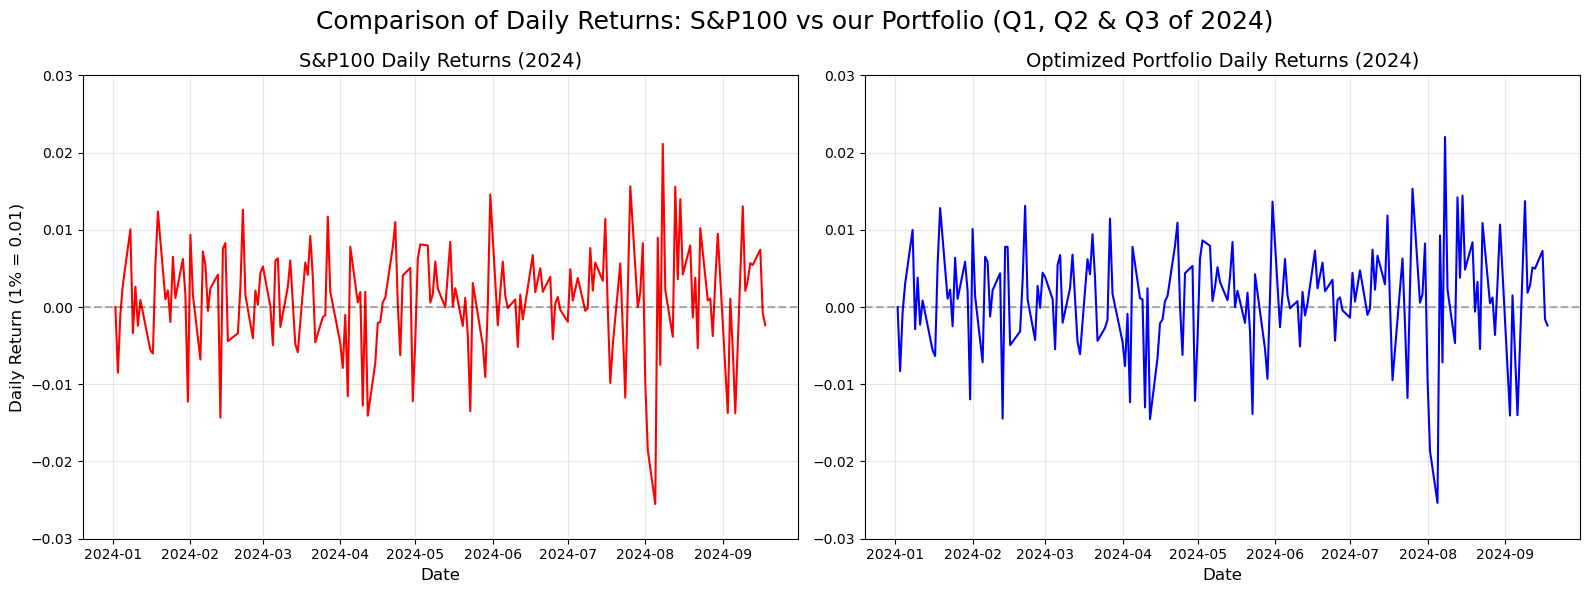

In [146]:
plt.figure(figsize=(16, 6))
plt.suptitle("Comparison of Daily Returns: S&P100 vs our Portfolio (Q1, Q2 & Q3 of 2024)",fontsize=18)

#SP100
plt.subplot(1, 2, 1)  #pos1
sns.lineplot(data=DRQ3, x=DRQ3.index, y='Benchmark', color='red')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("S&P100 Daily Returns (2024)", fontsize=14)
plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim(-0.03,0.03)
plt.grid(True, alpha=0.3)

#OUr stocks
plt.subplot(1, 2, 2) #pos2
sns.lineplot(data=DRQ3, x=DRQ3.index, y='Optimized_Portfolio', color='blue')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Optimized Portfolio Daily Returns (2024)", fontsize=14)
#plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.ylabel("")
plt.ylim(-0.03,0.03)
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

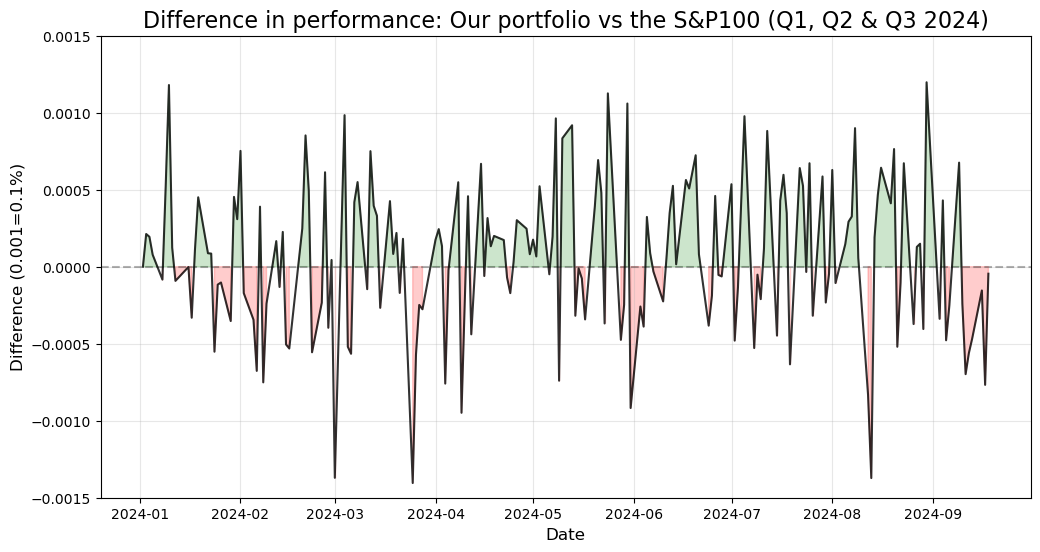

In [152]:
DRQ3['Difference'] = DRQ3['Optimized_Portfolio'] - DRQ3['Benchmark']

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=DRQ3, x=DRQ3.index, y='Difference', 
             color='black', alpha=0.8)
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Difference in performance: Our portfolio vs the S&P100 (Q1, Q2 & Q3 2024)", fontsize=16)
plt.ylabel("Difference (0.001=0.1%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim(-0.0015,0.0015)
plt.grid(True, alpha=0.3)

#fill positive and negatives
plt.fill_between(DRQ3.index, DRQ3['Difference'], 0, 
                 where=(DRQ3['Difference'] > 0), 
                 color='green', alpha=0.2, interpolate=True)
plt.fill_between(DRQ3.index, DRQ3['Difference'], 0, 
                 where=(DRQ3['Difference'] < 0), 
                 color='red', alpha=0.2)
plt.show()